In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
import itertools

from textwrap import wrap
from utils import *
from matplotlib import pyplot as plt
from pymongo import MongoClient
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn import preprocessing
from sklearn.kernel_approximation import (RBFSampler, Nystroem)
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

### Parâmetros do Matplotlib e Seaborn

In [2]:
%matplotlib inline
pd.options.mode.chained_assignment = None 
plt.rcParams['figure.figsize'] = [10, 5]
sns.set(rc={'figure.figsize':(15,10)})

### Preparação dos dados

### Agrupamento e filtragem de classes

Devido ao número de classes com poucas amostras foi necessário fazer uma técnica de Feature Engineering, para agrupar classes com poucas frequência em classes mais genéricas. A perda de informação nesse caso é justificada pelo fato das labels com valores pequenos no geral apresentarem um impacto negativo no modelo estatístico, sendo que o modelo preditivo tende a decidir por classificar para as labels cm maior número de amostras. __Classes antes do agrupamento:__

In [16]:
acidentes_prf = mongo_to_dataframe("acidentes_rodovias_2010_2019")
acidentes_prf.causa_acidente.str.strip().value_counts()

Falta de atenção                                                                  3617
Outras                                                                            3030
Falta de Atenção à Condução                                                       1180
Não guardar distância de segurança                                                 729
Ingestão de álcool                                                                 678
Velocidade incompatível                                                            449
Desobediência à sinalização                                                        299
Ingestão de Álcool                                                                 283
Defeito mecânico em veículo                                                        250
Dormindo                                                                           219
Desobediência às normas de trânsito pelo condutor                                  200
Velocidade Incompatível                    

__Classes após agrupamento:__ 

In [18]:
acidentes_prf.causa_acidente.str.strip().value_counts()

Falta de atenção                                   3917
Outras                                             3030
Desobediência de normas                            1994
Falta de atenção à condução                        1178
Ingestão de álcool e/ou substâncias psicoativas     977
Defeitos                                            448
Causas externas                                     232
Name: causa_acidente, dtype: int64

### Limpeza e padronização dos dados

In [80]:
def get_periodo(row, horario_column):
    
    horario = wrap(row[horario_column], 2)[0]
    
    if row[horario_column] == 'NAO_ESPECIFICADA':
        return 'NAO_ESPECIFICADA'
    elif horario >= '06' and horario < '12':
        return 'Amanhecer'
    elif horario >= '12' and horario < '18':
        return 'Pleno dia'
    elif horario >= '18' and horario < '19':
        return 'Anoitecer'
    elif horario >= '19' and horario <= '23':
        return 'Plena Noite'
    elif horario >= '00' and horario <= '06':
        return 'Madrugada'

In [151]:
acidentes_prf = mongo_to_dataframe("acidentes_rodovias_2010_2019")

dias = {
    'segunda-feira': 'Segunda',
    'terça-feira': 'Terça',
    'quarta-feira': 'Quarta',
    'quinta-feira': 'Quinta',
    'sexta-feira': 'Sexta',
    'sábado': 'Sábado',
    'domingo': 'Domingo'
}

uso_solo = {
    'Sim': 'Urbano',
    'Não': 'Rural'
}

tipos = {
    'Derramamento de carga': 'Outros',
    'Derramamento de Carga': 'Outros',
    'Danos Eventuais': 'Outros',
    'Danos eventuais': 'Outros',
    'Atropelamento de Animal': 'Atropelamento de animal',
    'Colisão com objeto móvel': 'Colisão com objeto em movimento',
    'Colisão com objeto estático': 'Colisão com objeto fixo',
    'Saída de leito carroçável': 'Saída de Pista'
}

causas = {
    'Sinalização da via insuficiente ou inadequada': 'Causas externas',
    'Fenômenos da natureza': 'Causas externas',
    'Mal súbito': 'Causas externas', 
    'Avarias e/ou desgaste excessivo no pneu': 'Desobediência de normas',  
    'Restrição de visibilidade': 'Causas externas', 
    'Agressão externa': 'Causas externas',
    'Carga excessiva e/ou mal acondicionada': 'Desobediência de normas', 
    'Ingestão de substâncias psicoativas': 'Desobediência de normas',
    'Objeto estático sobre o leito carroçável': 'Causas externas',  
    'Ingestão de álcool e/ou substâncias psicoativas pelo pedestre': 'Ingestão de álcool e/ou substâncias psicoativas',
    'Sinalização da via insuficiente ou inadequada': 'Defeitos',   
    'Desobediência às normas de trânsito pelo pedestre' : 'Desobediência de normas', 
    'Deficiência ou não acionamento do sistema de iluminação/sinalização do veículo' : 'Desobediência de normas',
    'Defeito mecânico em veículo': 'Defeitos',
    'Condutor dormindo' : 'Dormindo',
    'Não guardar distância de segurança': 'Desobediência de normas',
    'Ingestão de álcool': 'Ingestão de álcool e/ou substâncias psicoativas',
    'Defeito na via': 'Defeitos',
    'Ingestão de substâncias psicoativas': 'Ingestão de álcool e/ou substâncias psicoativas',
    'Velocidade incompatível': 'Desobediência de normas',          
    'Desobediência à sinalização': 'Desobediência de normas',
    'Dormindo': 'Falta de atenção',
    'Velocidade incompatível': 'Desobediência de normas',
    'Pista escorregadia': 'Causas externas',
    'Condutor dormindo': 'Desobediência de normas',
    'Defeito mecânico no veículo': 'Defeitos',
    'Falta de atenção do pedestre': 'Falta de atenção',
    'Defeito na via': 'Defeitos',
    'Animais na pista': 'Causas externas',
    'Ultrapassagem indevida': 'Desobediência de normas',
    'Avarias e/ou desgaste excessivo no pneu': 'Defeitos',
    'Ultrapassagem indevida': 'Desobediência de normas',
    'Carga excessiva e/ou mal acondicionada': 'Desobediência de normas',
    'Deficiência ou não acionamento do sistema de iluminação/sinalização do veículo': 'Defeitos',
    'Desobediência às normas de trânsito pelo condutor': 'Desobediência de normas',
}

columns_to_drop = ['data_inversa', 'horario', 'uf', 'ano', 'km', 'ignorados']

acidentes_prf.causa_acidente = acidentes_prf.causa_acidente.str.strip()
acidentes_prf.causa_acidente = acidentes_prf.causa_acidente.str.capitalize()
acidentes_prf.causa_acidente = acidentes_prf.causa_acidente.replace(causas)

acidentes_prf.horario = acidentes_prf.horario.str.strip()
acidentes_prf['fase_dia'] = acidentes_prf.apply(lambda row: get_periodo(row, 'horario'), axis = 1)

acidentes_prf.dia_semana = acidentes_prf.dia_semana.replace(dias)

acidentes_prf.uso_solo = acidentes_prf.uso_solo.str.strip()
acidentes_prf.uso_solo = acidentes_prf.uso_solo.replace(dias)

acidentes_prf.data_inversa = pd.to_datetime(acidentes_prf.data_inversa)
acidentes_prf['mes'] = acidentes_prf.data_inversa.dt.month

acidentes_prf.condicao_metereologica = acidentes_prf.condicao_metereologica.str.strip()
acidentes_prf.condicao_metereologica = acidentes_prf.condicao_metereologica.replace({'Céu Claro': 'Ceu Claro'})

acidentes_prf.tipo_pista = acidentes_prf.tipo_pista.str.strip()
acidentes_prf.tracado_via = acidentes_prf.tracado_via.str.strip()

acidentes_prf.tipo_acidente = acidentes_prf.tipo_acidente.str.strip()
acidentes_prf.tipo_acidente = acidentes_prf.tipo_acidente.replace(tipos)

acidentes_prf.classificacao_acidente = acidentes_prf.classificacao_acidente.str.strip()

acidentes_prf.br = acidentes_prf.br.replace({',':'.'})

acidentes_prf = acidentes_prf.drop(columns_to_drop, axis = 1)
acidentes_prf = acidentes_prf.dropna()

acidentes_prf.br = acidentes_prf.br.astype(float).astype(int)

acidentes_prf.sentido_via = acidentes_prf.sentido_via.str.strip()

In [71]:
acidentes_prf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11776 entries, 0 to 11780
Data columns (total 19 columns):
dia_semana                11776 non-null object
br                        11776 non-null int64
causa_acidente            11776 non-null object
tipo_acidente             11776 non-null object
classificacao_acidente    11776 non-null object
fase_dia                  11776 non-null object
sentido_via               11776 non-null object
condicao_metereologica    11776 non-null object
tipo_pista                11776 non-null object
tracado_via               11776 non-null object
uso_solo                  11776 non-null object
pessoas                   11776 non-null int64
mortos                    11776 non-null int64
feridos_leves             11776 non-null int64
feridos_graves            11776 non-null int64
ilesos                    11776 non-null int64
feridos                   11776 non-null int64
veiculos                  11776 non-null int64
mes                       11776 non

### Balanceamento de classes

In [96]:
acidentes_prf.causa_acidente.value_counts()

Falta de atenção                                   3917
Outras                                             3030
Desobediência de normas                            1994
Falta de atenção à condução                        1178
Ingestão de álcool e/ou substâncias psicoativas     977
Defeitos                                            448
Causas externas                                     232
Name: causa_acidente, dtype: int64

In [152]:
df_falta_atencao = acidentes_prf[acidentes_prf.causa_acidente == 'Falta de atenção']
df_outras = acidentes_prf[acidentes_prf.causa_acidente == 'Outras']
df_desobediencia = acidentes_prf[acidentes_prf.causa_acidente == 'Desobediência de normas']
df_falta_atencao_conducao = acidentes_prf[acidentes_prf.causa_acidente == 'Falta de atenção à condução']
df_ingestao_alcool = acidentes_prf[acidentes_prf.causa_acidente == 'Ingestão de álcool e/ou substâncias psicoativas']
df_defeitos = acidentes_prf[acidentes_prf.causa_acidente == 'Defeitos']
df_causas_externas = acidentes_prf[acidentes_prf.causa_acidente == 'Causas externas']

# Up-Sample
df_ingestao_alcool = resample(df_ingestao_alcool, replace = True, n_samples = 1178, random_state = 42)
df_defeitos = resample(df_defeitos, replace = True, n_samples = 1178, random_state = 42)
df_causas_externas = resample(df_causas_externas, replace = True, n_samples = 1178, random_state = 42)

# Down-Sample
df_falta_atencao = resample(df_falta_atencao, replace = False, n_samples = 1178, random_state = 42)
df_outras = resample(df_outras, replace = False, n_samples = 1178, random_state = 42)
df_desobediencia = resample(df_desobediencia, replace = False, n_samples = 1178, random_state = 42)

acidentes_prf = pd.concat([df_falta_atencao, df_outras, df_desobediencia, df_falta_atencao_conducao, df_ingestao_alcool, df_defeitos, df_causas_externas])
acidentes_prf.causa_acidente.value_counts()

Causas externas                                    1178
Outras                                             1178
Desobediência de normas                            1178
Ingestão de álcool e/ou substâncias psicoativas    1178
Falta de atenção                                   1178
Falta de atenção à condução                        1178
Defeitos                                           1178
Name: causa_acidente, dtype: int64

### Feature Encoding

* Atribuição de valores numéricos para features categóricas textuais

In [153]:
le = preprocessing.LabelEncoder()

acidentes_prf.dia_semana = le.fit_transform(acidentes_prf.dia_semana)
acidentes_prf.tipo_acidente = le.fit_transform(acidentes_prf.tipo_acidente)
acidentes_prf.classificacao_acidente = le.fit_transform(acidentes_prf.classificacao_acidente)
acidentes_prf.fase_dia = le.fit_transform(acidentes_prf.fase_dia)
acidentes_prf.sentido_via = le.fit_transform(acidentes_prf.sentido_via)
acidentes_prf.condicao_metereologica = le.fit_transform(acidentes_prf.condicao_metereologica)
acidentes_prf.tipo_pista = le.fit_transform(acidentes_prf.tipo_pista)
acidentes_prf.tracado_via = le.fit_transform(acidentes_prf.tracado_via)
acidentes_prf.uso_solo = le.fit_transform(acidentes_prf.uso_solo)

### Feature Selection

Foram utilizados o LinearSVC e ExtraTreesClassifier juntamente com SelectFromModel, permitindo a exclusão de features categorizadas como menos importantes a partir da atribuição de pesos de coeficientes.

In [154]:
X = acidentes_prf.drop('causa_acidente', axis = 1) 
y = acidentes_prf.causa_acidente

In [155]:
clf = ExtraTreesClassifier()
clf = clf.fit(X, y)

model = SelectFromModel(clf, prefit=True)
Trees_X_new = model.transform(X)

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
Linear_X_new = model.transform(X)

print('Data matrix shape before feature selection: ' + str(X.shape))
print('Data matrix shape after ExtraTreesClassifier feature selection: ' + str(Trees_X_new.shape))
print('Data matrix shape after LinearSVC feature selection: ' + str(Linear_X_new.shape))
X_new = Trees_X_new

/home/iago/anaconda3/envs/tccEnv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Data matrix shape before feature selection: (8246, 18)
Data matrix shape after ExtraTreesClassifier feature selection: (8246, 7)
Data matrix shape after LinearSVC feature selection: (8246, 18)


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 <a list of 17 Text xticklabel objects>)

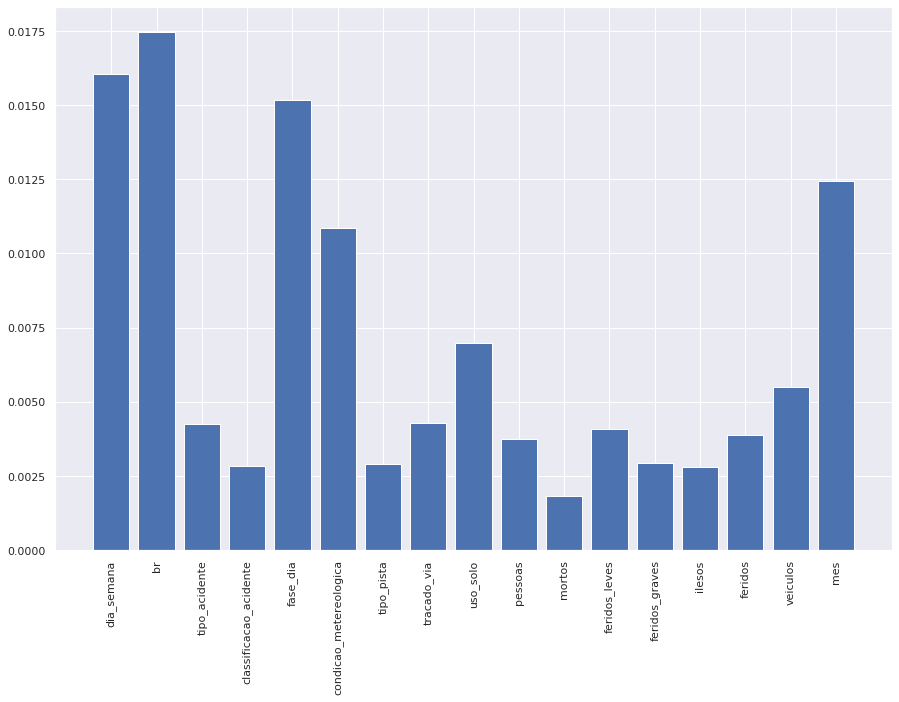

In [168]:
feature_importance = clf.feature_importances_
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        clf.estimators_], 
                                        axis = 0)

plt.bar(X.columns, feature_importance_normalized)
plt.title('Importância das features com coeficientes de peso')
plt.xticks(rotation = 90)

### Separação dos dados de Treino e Teste

In [156]:
X_train, X_test, y_train, y_test = train_test_split(
    X_new,
    y,
    test_size = 0.20,
    random_state = 42
)

### Treinamento do modelo para teste do melhor valor para K

* Valores padrões de K normalmente são ímpar e correspondem a SQRT(N) / 2 ou SQRT(N) onde N = quantidade de amostras no DataSet.

### Modelo sem Re-Sample

Melhor valor de K para KNN: 46
Acurácia máxima com melhor K: 0.4032258064516129


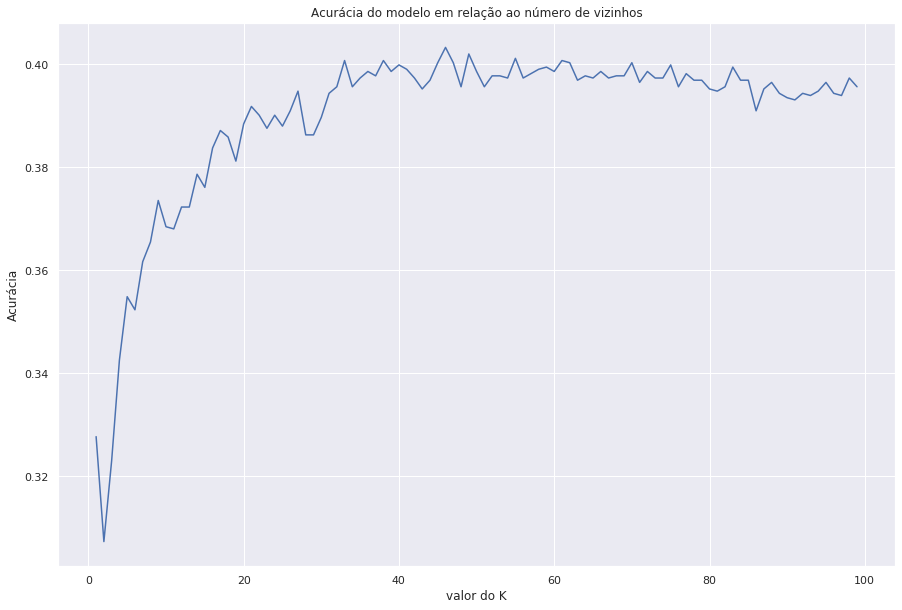

In [147]:
k_range = range(1, 100)
scores = {}
scores_list = []

for k in k_range:

    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    
    scores[k] = knn.score(X_test, y_test)
    scores_list.append(knn.score(X_test, y_test))


plt.plot(k_range, scores_list)
plt.title('Acurácia do modelo em relação ao número de vizinhos')
plt.xlabel('valor do K')
plt.ylabel('Acurácia')

np_k_scores = np.asarray(scores_list)
best_k = np.argmax(np_k_scores) + 1

knn = KNeighborsClassifier(n_neighbors = best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print('Melhor valor de K para KNN: ' + str(best_k))
print('Acurácia máxima com melhor K: ' + str(max(scores_list)))

### Modelo com Re-sample

Melhor valor de K para KNN: 1
Acurácia máxima com melhor K: 0.5224242424242425


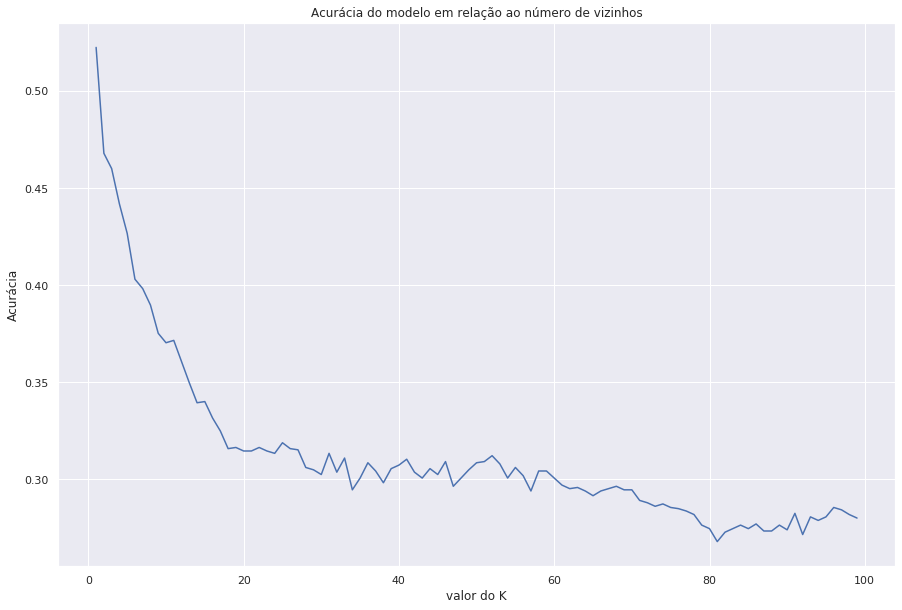

In [157]:
k_range = range(1, 100)
scores = {}
scores_list = []

for k in k_range:

    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    
    scores[k] = knn.score(X_test, y_test)
    scores_list.append(knn.score(X_test, y_test))


plt.plot(k_range, scores_list)
plt.title('Acurácia do modelo em relação ao número de vizinhos')
plt.xlabel('valor do K')
plt.ylabel('Acurácia')

np_k_scores = np.asarray(scores_list)
best_k = np.argmax(np_k_scores) + 1

knn = KNeighborsClassifier(n_neighbors = best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print('Melhor valor de K para KNN: ' + str(best_k))
print('Acurácia máxima com melhor K: ' + str(max(scores_list)))

### Matriz de confusão do modelo

* Relação entre classe real das amostras de teste e a classe resultante da predição do modelo

### Modelo sem Re-Sample

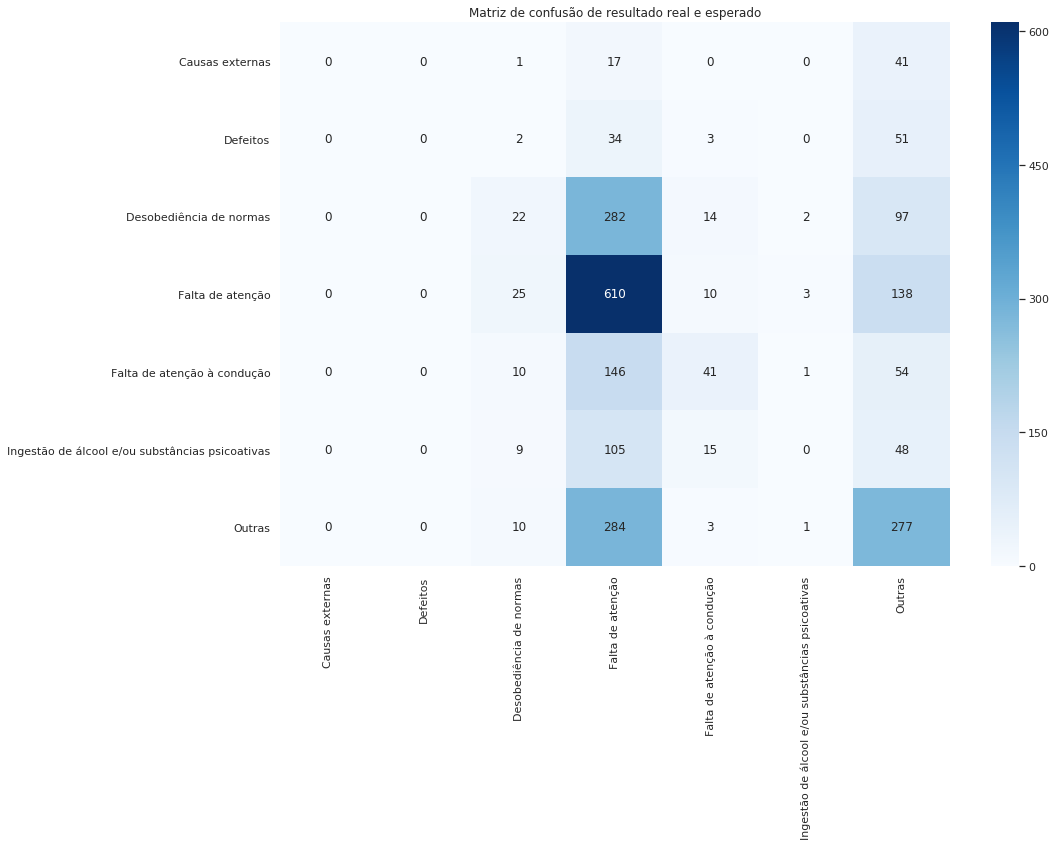

In [148]:
unique_label = np.unique([y_test, y_pred])

confusion_mtx = pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels = unique_label), 
    index = [x for x in unique_label], 
    columns = [x for x in unique_label]
)

sns.heatmap(confusion_mtx, annot = True, cmap = plt.cm.Blues, fmt = 'd')

# Fix para erros na versão atual do Seaborn que cortam lim superior e inferior da imagem
b, t = plt.ylim()
b += 0.5
t -= 0.5

plt.ylim(b, t)
plt.title('Matriz de confusão de resultado real e esperado')
plt.show()

### Modelo com Re-Sample

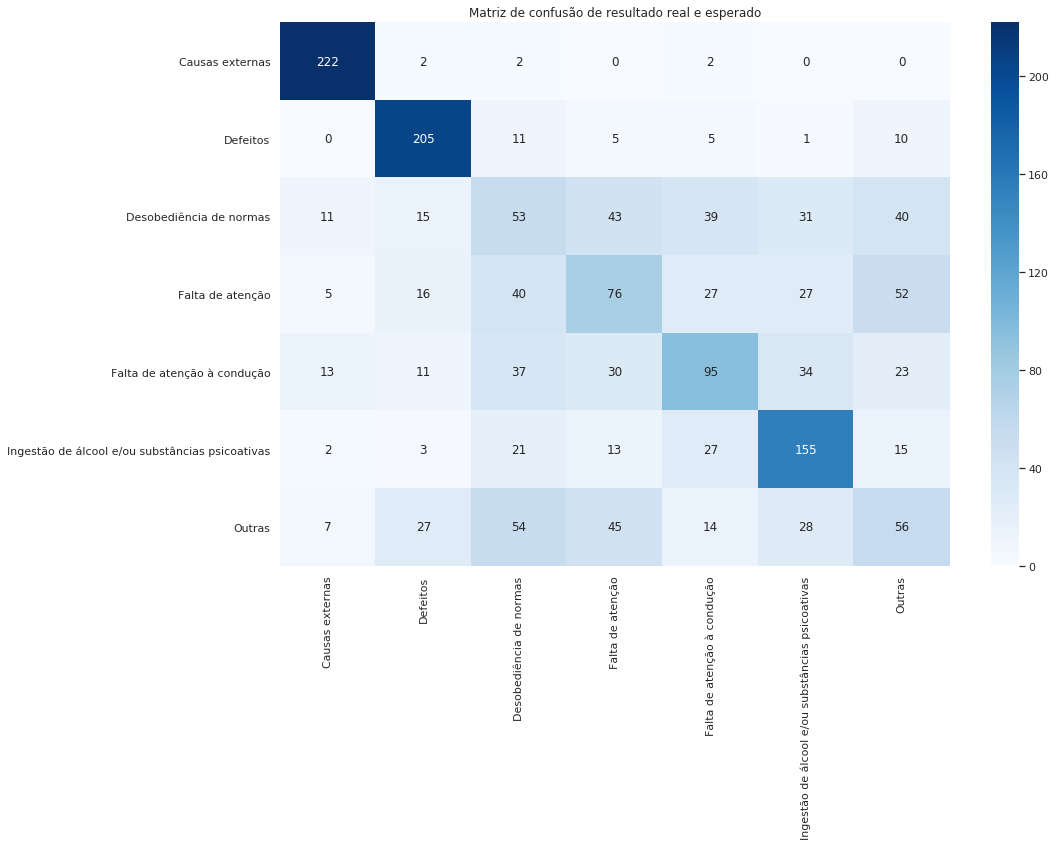

In [158]:
unique_label = np.unique([y_test, y_pred])

confusion_mtx = pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels = unique_label), 
    index = [x for x in unique_label], 
    columns = [x for x in unique_label]
)

sns.heatmap(confusion_mtx, annot = True, cmap = plt.cm.Blues, fmt = 'd')

# Fix para erros na versão atual do Seaborn que cortam lim superior e inferior da imagem
b, t = plt.ylim()
b += 0.5
t -= 0.5

plt.ylim(b, t)
plt.title('Matriz de confusão de resultado real e esperado')
plt.show()

### Fit de test no modelo para compravação de underfitting

In [150]:
k_range = range(1, 100)
scores = {}
scores_list = []
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_test, y_test)
    
    y_pred = knn.predict(X_train)
    scores[k] = metrics.accuracy_score(y_train, y_pred)
    scores_list.append(metrics.accuracy_score(y_train, y_pred))
    
    knn_score = knn.score(X_train, y_train)
    
    k_scores.append(knn_score)
    
np_k_scores = np.asarray(k_scores)
best_k = np.argmax(np_k_scores) + 1
print('Best k to KNN Classifier: ' + str(best_k))

print('Best accuracy with knn: ' + str(max(scores_list)))

Best k to KNN Classifier: 60
Best accuracy with knn: 0.38895966029723994


### Outras Abordagens

* Utilizando a proposta de seleção de algoritmos do SciKit-Learn e levando em consideração o conjunto de amostras atual (n > 10k) foram utilizadas duas aproximações, com o uso de SGD Classifier e Kernel Aproximation, ambos com resultados semelhantes porém inferiores ao KNN.

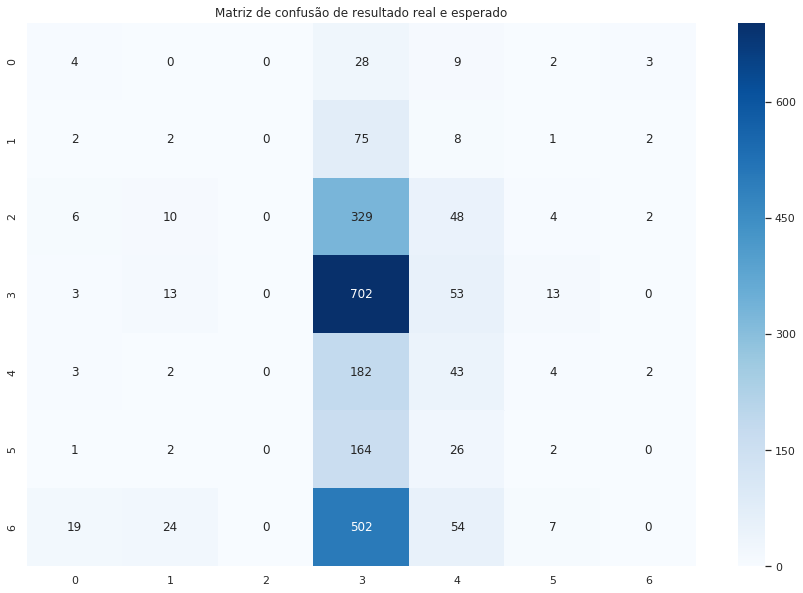

0.3196095076400679


In [14]:
model = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
       random_state=42, shuffle=True, tol=0.001, verbose=0, warm_start=False)

model.fit(X_train, y_train)

predicted = model.predict(X_test)

matrix = confusion_matrix(y_test, predicted)

sns.heatmap(matrix, annot = True, cmap = plt.cm.Blues, fmt = 'd')

b, t = plt.ylim()
b += 0.5
t -= 0.5

plt.ylim(b, t)
plt.title('Matriz de confusão de resultado real e esperado')
plt.show()

accuracy = model.score(X=X_test, y=y_test)
print(accuracy)

In [140]:
model = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
       random_state=42, shuffle=True, tol=0.001, verbose=0, warm_start=False)

rbf_feature = RBFSampler(gamma=1, random_state=1)
X_features = rbf_feature.fit_transform(X_train)
X_features2 = rbf_feature.fit_transform(X_test)
model.fit(X_features, y_train)
model.score(X_features2, y_test)

0.32385398981324276

### Avaliação do Modelo

* Treinamento com set de teste com resultados baixos e semelhantes ao set train indicam underfitting no modelo, impedindo uma generalização adequada para predição correta.
* Utilização de Re-Sample comprova que aumento do número de amostras teria impacto positivo na melhoria da acurácia do modelo.
* Utilização de Re-sample leva a um overfitting do modelo.

### Random Forest sem Re-Sample

In [149]:
rcf = RandomForestClassifier()
rcf.fit(X_train, y_train)

score = rcf.score(X_test, y_test)
score

/home/iago/anaconda3/envs/tccEnv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.416383701188455

### Random Forest com Re-Sample

In [159]:
rcf = RandomForestClassifier()
rcf.fit(X_train, y_train)

score = rcf.score(X_test, y_test)
score

/home/iago/anaconda3/envs/tccEnv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.5903030303030303